In [1]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI, Predictive
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDiagonalNormal, Trace_ELBO
from numpyro.infer.reparam import CircularReparam

from asteroglitch.model import GlitchModel

from corner import corner

In [2]:
track = pd.read_csv('../examples/data/modes.csv')
track.head()

,frac_age,delta_nu_fit,nu_max,nu_0_1,nu_0_2,nu_0_3,nu_0_4,nu_0_5,nu_0_6,nu_0_7,...,nu_0_32,nu_0_33,nu_0_34,nu_0_35,nu_0_36,nu_0_37,nu_0_38,nu_0_39,nu_0_40,surface_he4
0,0.000016,11.884045,150.680452,0.0,34.481794,49.329712,63.195077,75.913367,87.630758,99.483102,...,392.064627,403.710370,415.297909,426.924218,438.655667,450.550178,462.546781,474.658899,486.825847,0.239966
1,0.000017,12.140476,154.893200,0.0,35.203007,50.376320,64.548471,77.583389,89.569246,101.679667,...,400.620086,412.538305,424.386957,436.252351,448.212638,460.326691,472.558635,484.919720,497.325734,0.239967
2,0.000017,12.343045,158.238356,0.0,35.772049,51.202159,65.616199,78.900744,91.100159,103.413323,...,407.368711,419.505074,431.563921,443.619056,455.762984,468.048949,480.469626,493.018551,505.616340,0.239968
3,0.000018,12.503403,160.898485,0.0,36.222266,51.855582,66.460893,79.942765,92.312228,104.785371,...,412.708426,425.019262,437.245702,449.452226,461.742276,474.164224,486.734715,499.427290,512.179364,0.239969
4,0.000018,12.633487,163.061612,0.0,36.587368,52.385499,67.145867,80.787635,93.295718,105.898357,...,417.037759,429.491253,441.854064,454.184875,466.594022,479.127384,491.819429,504.626946,517.505773,0.239969


In [3]:
profile = track.loc[600]

In [4]:
nu_index = [f'nu_0_{i}' for i in range(10, 30)]

def get_nu(profile):
    nu = profile[nu_index].to_numpy().astype(float)
    nu = nu[nu > 0.0]  # Values equal to zero correspond to no calculation
    return nu

nu = get_nu(profile)

In [5]:
# Scaling relation nu_max
nu_max_sca = profile['nu_max']
print('nu_max ~', round(nu_max_sca, 2), 'muHz')

# Delta_nu fit to radial modes about nu_max
delta_nu_fit = profile['delta_nu_fit']
print('delta_nu ~', round(delta_nu_fit, 2), 'muHz')

nu_max ~ 2853.19 muHz
delta_nu ~ 128.7 muHz


In [6]:
nu_err = 1e-6 * (nu - nu_max_sca)**2

In [7]:
rng = np.random.default_rng(42)

In [8]:
def add_noise(rng, nu, nu_err):
    return rng.normal(nu, nu_err)

In [9]:
nu_obs = add_noise(rng, nu, nu_err)

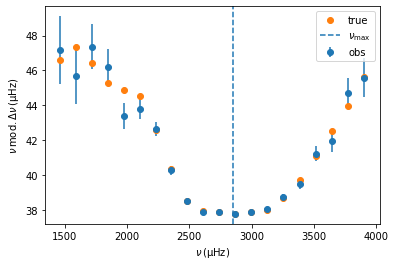

In [10]:
nu_mod = nu % delta_nu_fit
nu_mod_obs = nu_obs % delta_nu_fit

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod_obs, yerr=nu_err, fmt='o', label='obs')
ax.plot(nu, nu_mod, 'o', label='true')

ax.axvline(nu_max_sca, linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [11]:
delta_nu = [delta_nu_fit, 1.0]
nu_max = [nu_max_sca, 0.05*nu_max_sca]

In [12]:
glitch = GlitchModel(delta_nu, nu_max, nu=nu_obs, nu_err=nu_err)

/Users/ajl573/Repos/alexlyttle/helium-glitch-fitter/asteroglitch/model.py:198: UserWarning: Neither argument 'n' nor 'num_orders' passed, inferring num_orders = 20 from final dimension of 'nu'.
  warnings.warn("Neither argument 'n' nor 'num_orders' passed, " +


In [19]:
sampler = NUTS(glitch.posterior)
mcmc = MCMC(sampler, num_warmup=100, num_samples=100)

In [20]:
mcmc.run(random.PRNGKey(0))

/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:979: UserWarning: Continuous inference poorly handles circular sample site 'phi_he'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_he': CircularReparam()}).
  warnings.warn(msg, UserWarning)
/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:979: UserWarning: Continuous inference poorly handles circular sample site 'phi_cz'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_cz': CircularReparam()}).
  warnings.warn(msg, UserWarning)
sample: 100%|██████████| 200/200 [00:06<00:00, 29.34it/s, 11 steps of size 1.10e-03. acc. prob=0.28]


In [21]:
trace = az.from_numpyro(mcmc)

(array([  0.,   0.,   0.,   0.,   0., 100.,   0.,   0.,   0.,   0.]),
 array([1462.36523384, 1462.46523384, 1462.56523384, 1462.66523384,
        1462.76523384, 1462.86523384, 1462.96523384, 1463.06523384,
        1463.16523384, 1463.26523384, 1463.36523384]),
 <BarContainer object of 10 artists>)

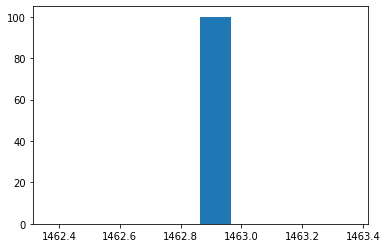

In [28]:
plt.hist(trace.posterior.nu_obs.values[:, :, 0].squeeze(), )

In [33]:
import xarray as xa

In [128]:
nu_test = np.stack([nu_obs, nu_obs])
nu_test.shape

(2, 20)

In [131]:
nu_test = xa.DataArray(nu_test, coords=(('l', [0, 1]), ('n', glitch.n)))

In [132]:
nu_test

<xarray.DataArray (l: 2, n: 20)>
array([[1462.86523384, 1590.05577118, 1720.45731507, 1847.99931756,
        1973.87245805, 2102.97718849, 2230.51299814, 2356.85451407,
        2483.77933659, 2611.84887416, 2740.54508997, 2869.15063732,
        2997.9645599 , 3126.85774841, 3256.23561773, 3385.65425161,
        3516.10546445, 3645.50428651, 3777.01324114, 3906.57152472],
       [1462.86523384, 1590.05577118, 1720.45731507, 1847.99931756,
        1973.87245805, 2102.97718849, 2230.51299814, 2356.85451407,
        2483.77933659, 2611.84887416, 2740.54508997, 2869.15063732,
        2997.9645599 , 3126.85774841, 3256.23561773, 3385.65425161,
        3516.10546445, 3645.50428651, 3777.01324114, 3906.57152472]])
Coordinates:
  * l        (l) int64 0 1
  * n        (n) int64 10 11 12 13 14 15 16 17 18 ... 21 22 23 24 25 26 27 28 29

In [92]:
ds = xa.Dataset({'nu_test': nu_test})

In [ ]:
ds

In [95]:
az.InferenceData(observed_data=ds)

Inference data with groups:
	> observed_data

In [108]:
nu_test = mcmc.get_samples(group_by_chain=True)['nu']

In [109]:
nu_test.shape

(1, 100, 20)

In [126]:
freq = ['nu', 'nu_obs', 'nu_obs_unobserved', 'nu_asy', 'nu_obs_observed']

trace = az.from_dict(posterior=mcmc.get_samples(group_by_chain=True),
            coords={'n': glitch.n},
            dims={k: ['n'] for k in freq})

In [127]:
trace

Inference data with groups:
	> posterior

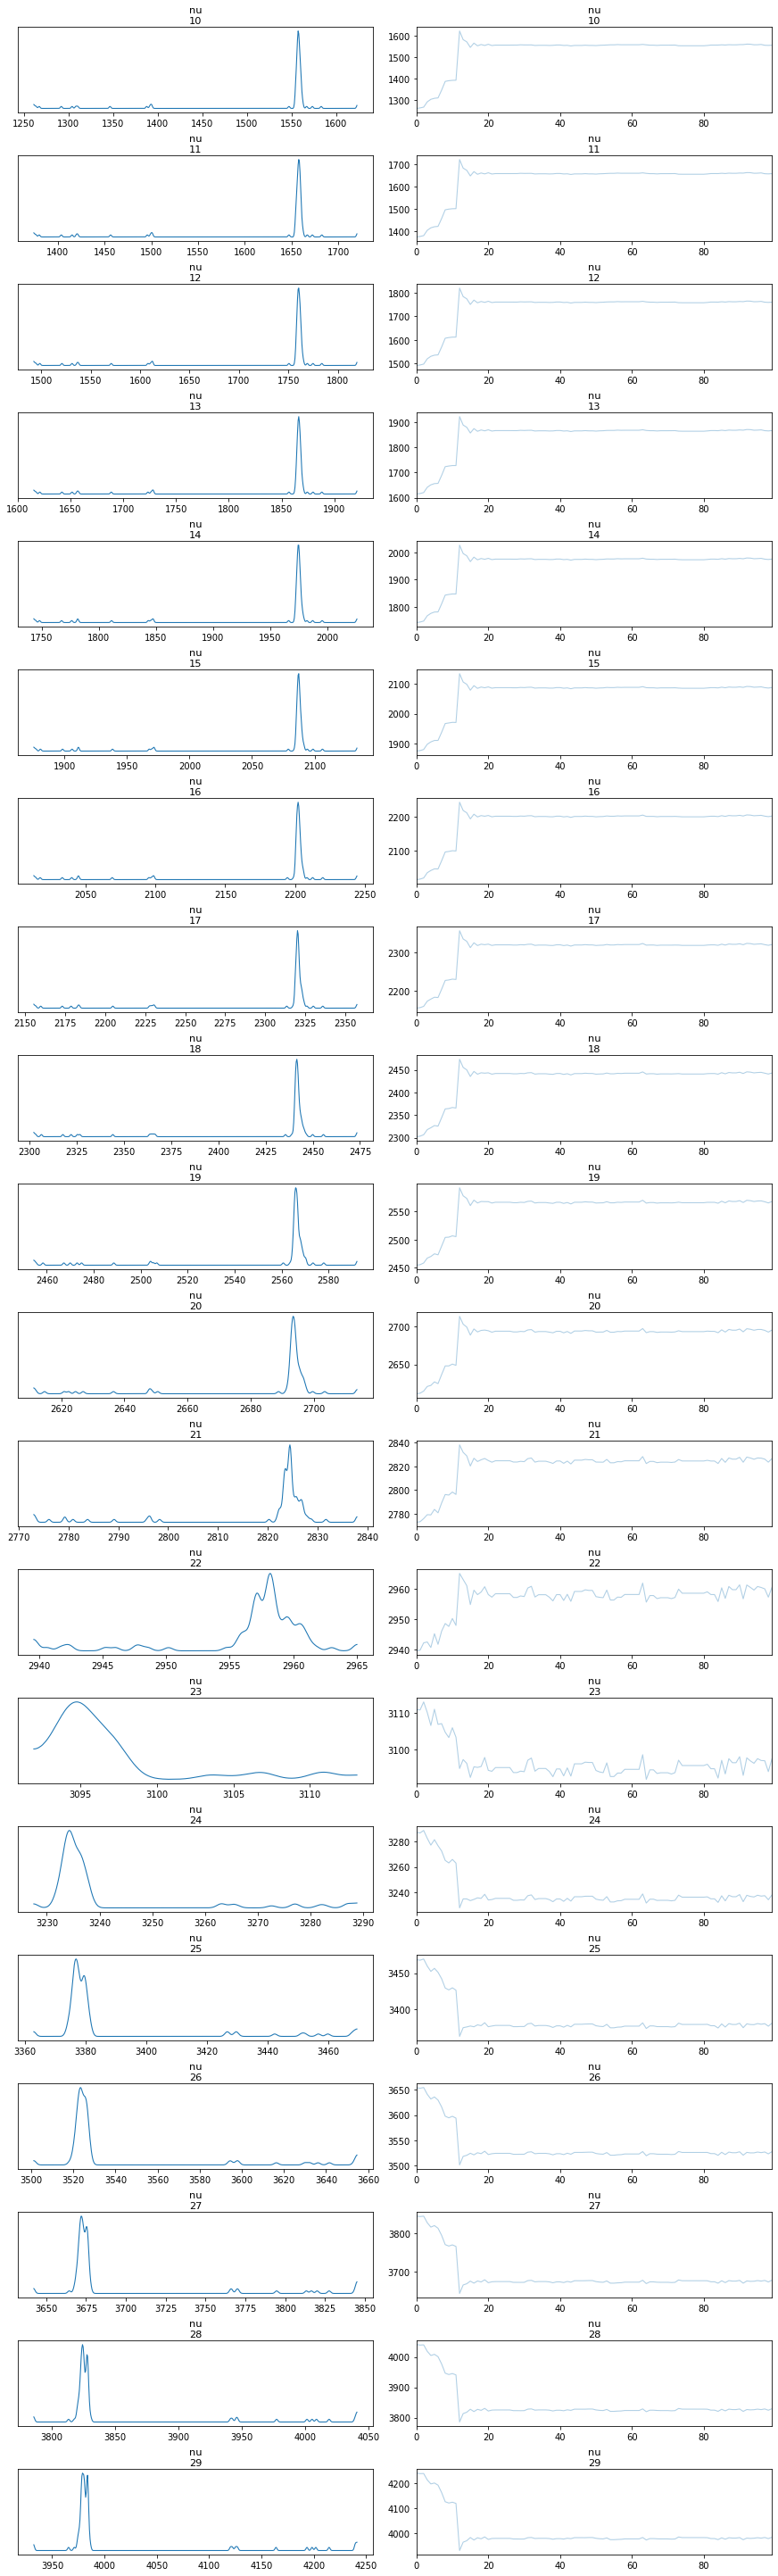

In [117]:
az.plot_trace(trace, var_names=['nu'], compact=False);

In [14]:
prior_predictive = Predictive(glitch.prior, num_samples=num_chains*num_samples, batch_ndims=2)

In [15]:
rng_seed = random.PRNGKey(42)
rng_seed, rng_key = random.split(rng_seed)

In [16]:
prior_predictive_samples = prior_predictive(rng_key)

In [17]:
trace = az.from_dict(
    prior_predictive=prior_predictive_samples, 
    observed_data=glitch.observed_data,
    constant_data=glitch.constant_data,
    predictions_constant_data=glitch.predictions_constant_data,
)

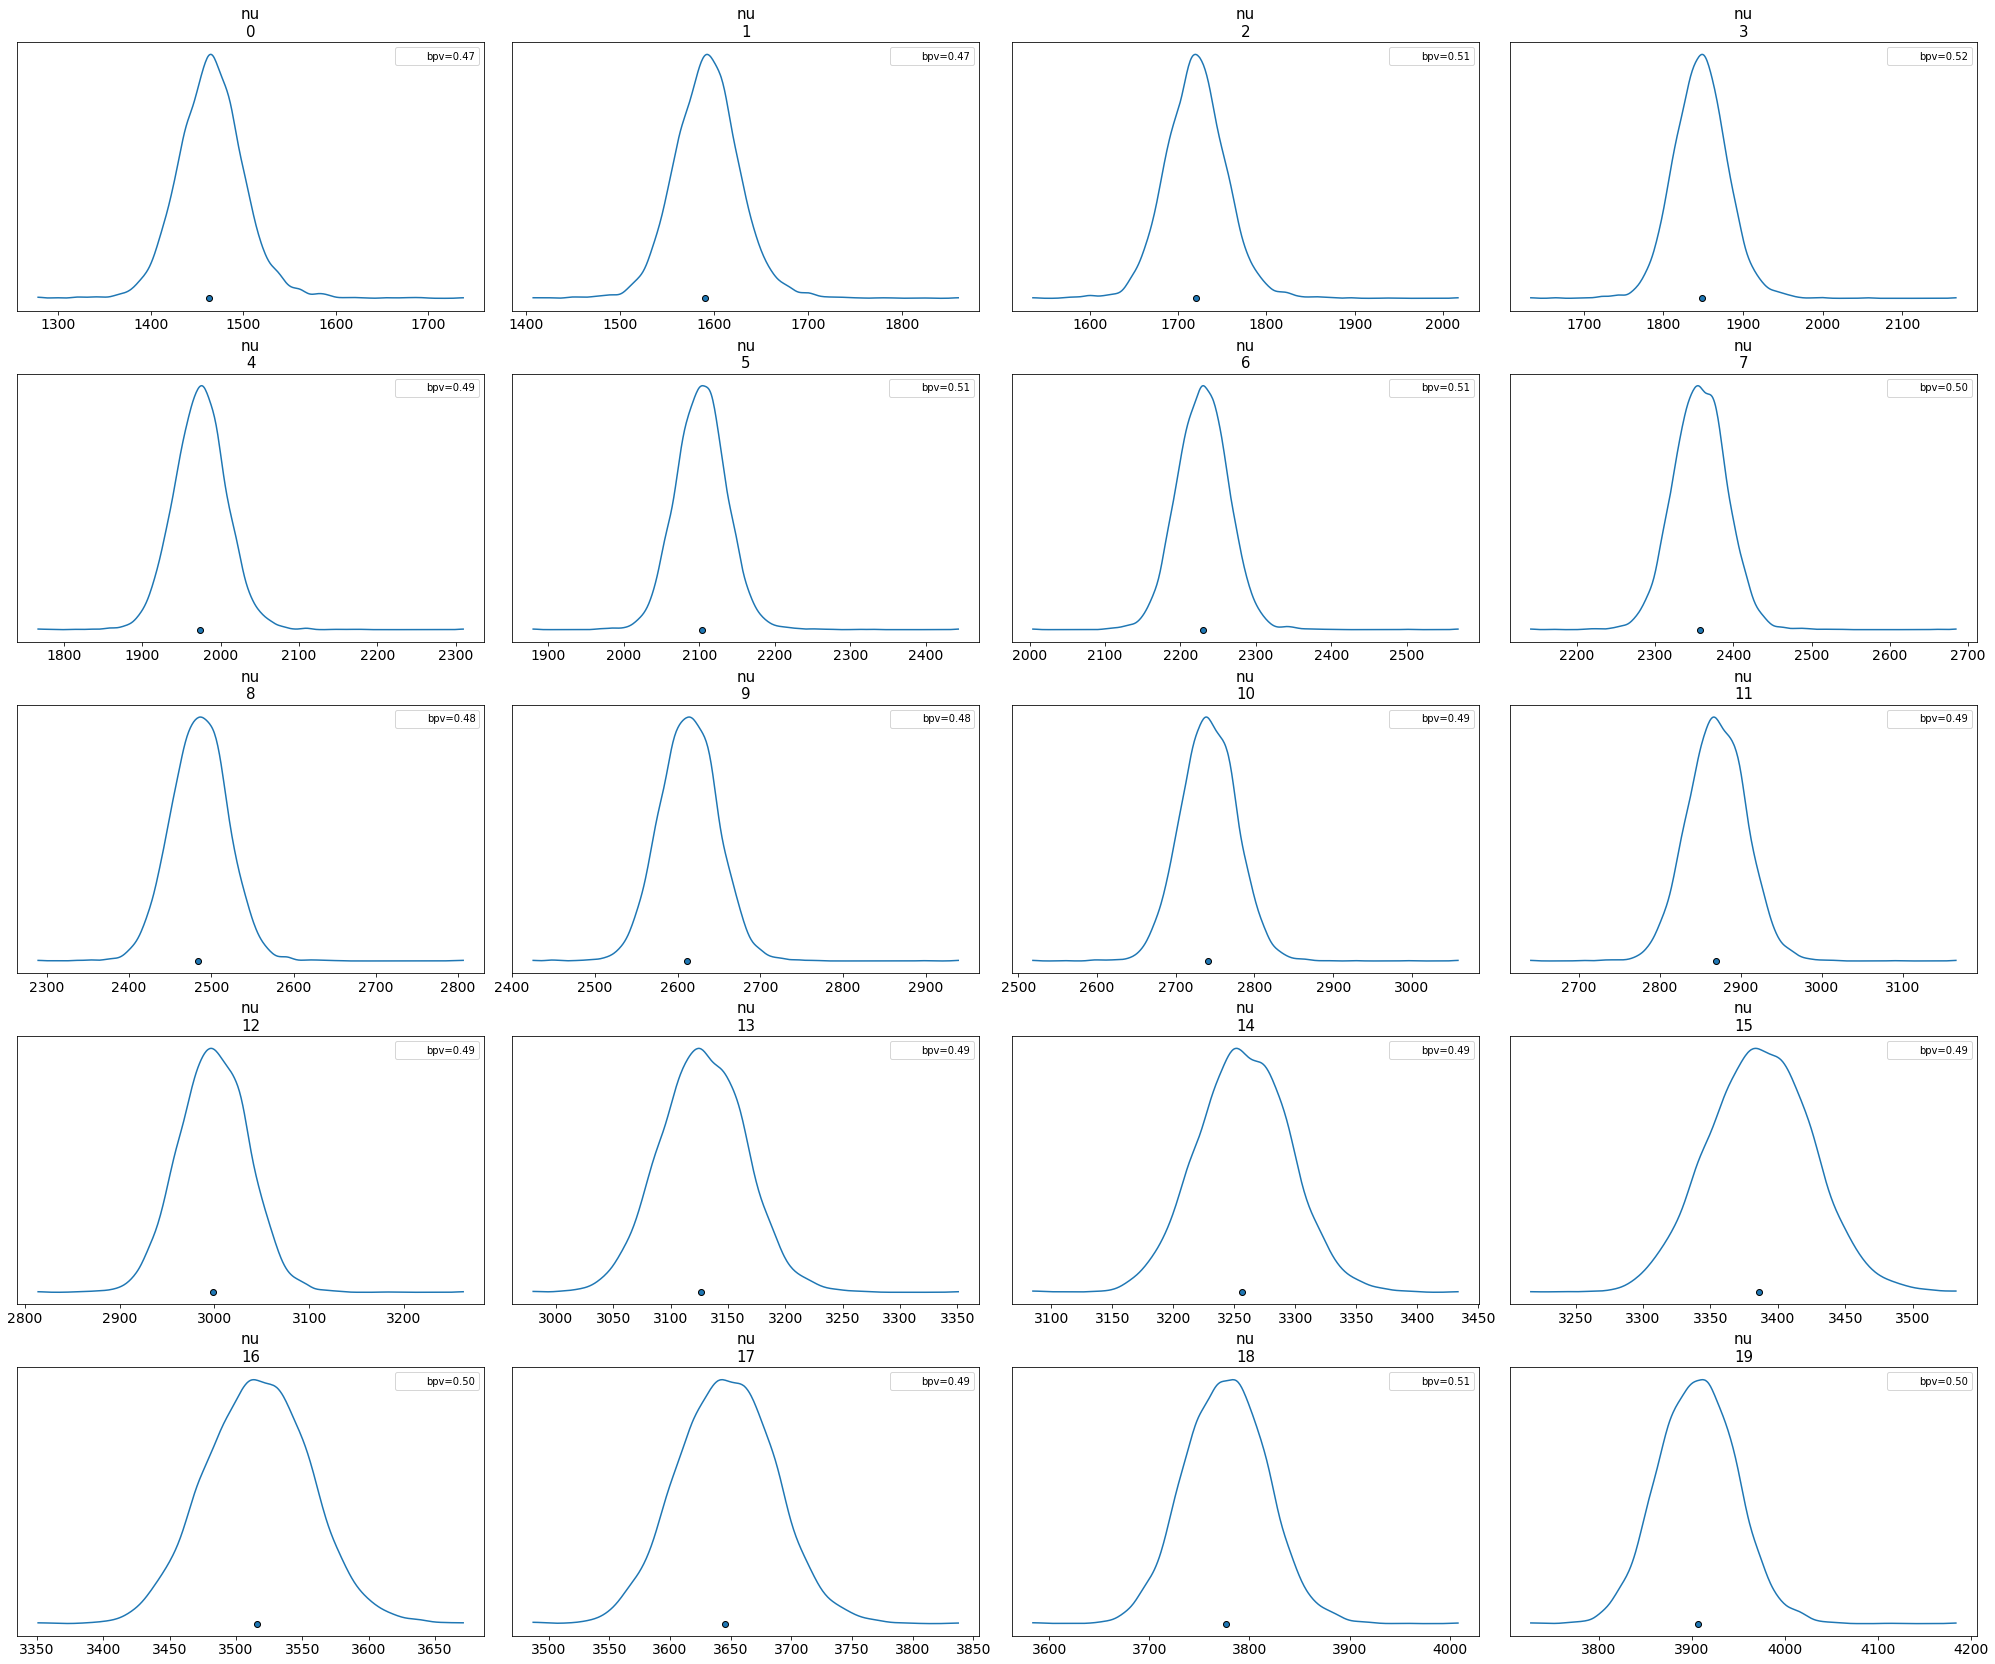

In [18]:
ax = az.plot_bpv(trace, group='prior', kind='t_stat', flatten=['chain', 'draws']);

In [19]:
init_strategy = lambda site=None: init.init_to_median(site=site, num_samples=1000)

Now lets diagonalize the prior

In [20]:
prior = numpyro.handlers.reparam(fn=glitch.prior, config=glitch.prior_reparam)

In [21]:
posterior = numpyro.handlers.reparam(fn=glitch.posterior, config=glitch.posterior_reparam)

In [22]:
# guide = numpyro.infer.autoguide.AutoDiagonalNormal(prior, init_loc_fn=init_strategy)
# optim = Adam(step_size=1e-3)
# loss = Trace_ELBO()
# svi = SVI(prior, guide, optim, loss)

In [23]:
# rng_seed, rng_key = random.split(rng_seed)

In [24]:
# svi_result = svi.run(rng_key, 50000)

In [25]:
# neutra = numpyro.infer.reparam.NeuTraReparam(guide, svi_result.params)

In [26]:
# posterior = neutra.reparam(posterior)

In [27]:
nuts = NUTS(posterior, target_accept_prob=0.99, init_strategy=init_strategy)
mcmc = MCMC(nuts, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [28]:
rng_seed, rng_key = random.split(rng_seed)

In [29]:
mcmc.run(rng_key)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [30]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
                alpha      0.00      0.00      0.00      0.00      0.00     25.02      1.17
                   b0      0.02      0.02      0.02      0.00      0.05    184.36      1.03
                   b1      0.00      0.00      0.00      0.00      0.00     74.56      1.06
                   c0 2265333.63 729878.18 2236814.35 1044195.79 3390466.98    128.78      1.04
             delta_nu    128.79      0.35    128.76    128.23    129.30     45.94      1.10
            delta_tau      0.00      0.00      0.00      0.00      0.00    153.14      1.03
              epsilon      1.28      0.06      1.28      1.18      1.37     46.03      1.11
                  err      0.10      0.04      0.09      0.03      0.16    430.45      1.01
               nu_max   2830.03    132.51   2831.27   2606.65   3034.33    287.61      1.02
 nu_obs_unobserved[0]  25692.65  80169.47   7488.40 -80763.10 174971.27    

In [31]:
group_by_chain = True
posterior_samples = mcmc.get_samples(group_by_chain=group_by_chain)
sample_stats = mcmc.get_extra_fields(group_by_chain=group_by_chain)

In [32]:
group_dict={
    'posterior': posterior_samples,
    'sample_stats': sample_stats,
}

In [33]:
trace.add_groups(**group_dict)

In [34]:
var_names = ['delta_nu', 'nu_max', 'epsilon', 'alpha', 
             'b0', 'b1', 'tau_he', 'phi_he', 
             'c0', 'tau_cz', 'phi_cz', 'he_nu_max']

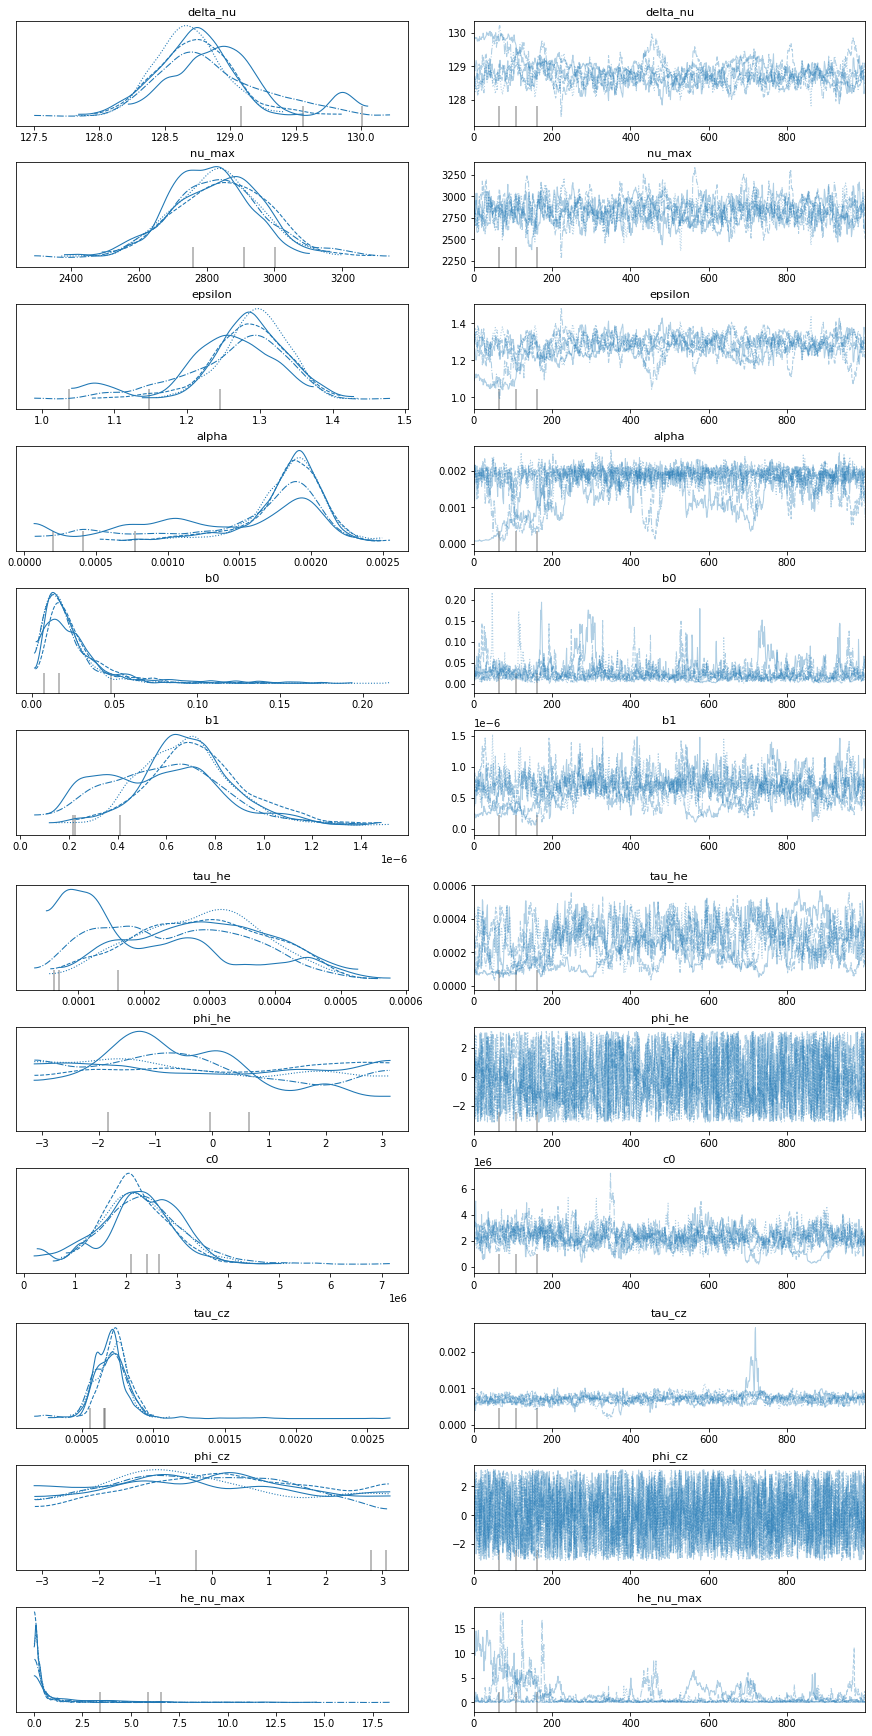

In [35]:
az.plot_trace(trace, var_names=var_names);

(array([   5.,   20.,   45.,  234.,  602., 1495., 1333.,  661.,  460.,
         145.]),
 array([-3.45077798, -2.97920969, -2.50764141, -2.03607312, -1.56450484,
        -1.09293655, -0.62136826, -0.14979998,  0.32176831,  0.79333659,
         1.26490488]),
 <BarContainer object of 10 artists>)

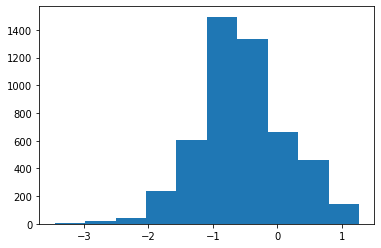

In [36]:
plt.hist(np.log10(posterior_samples['he_nu_max']).flatten())

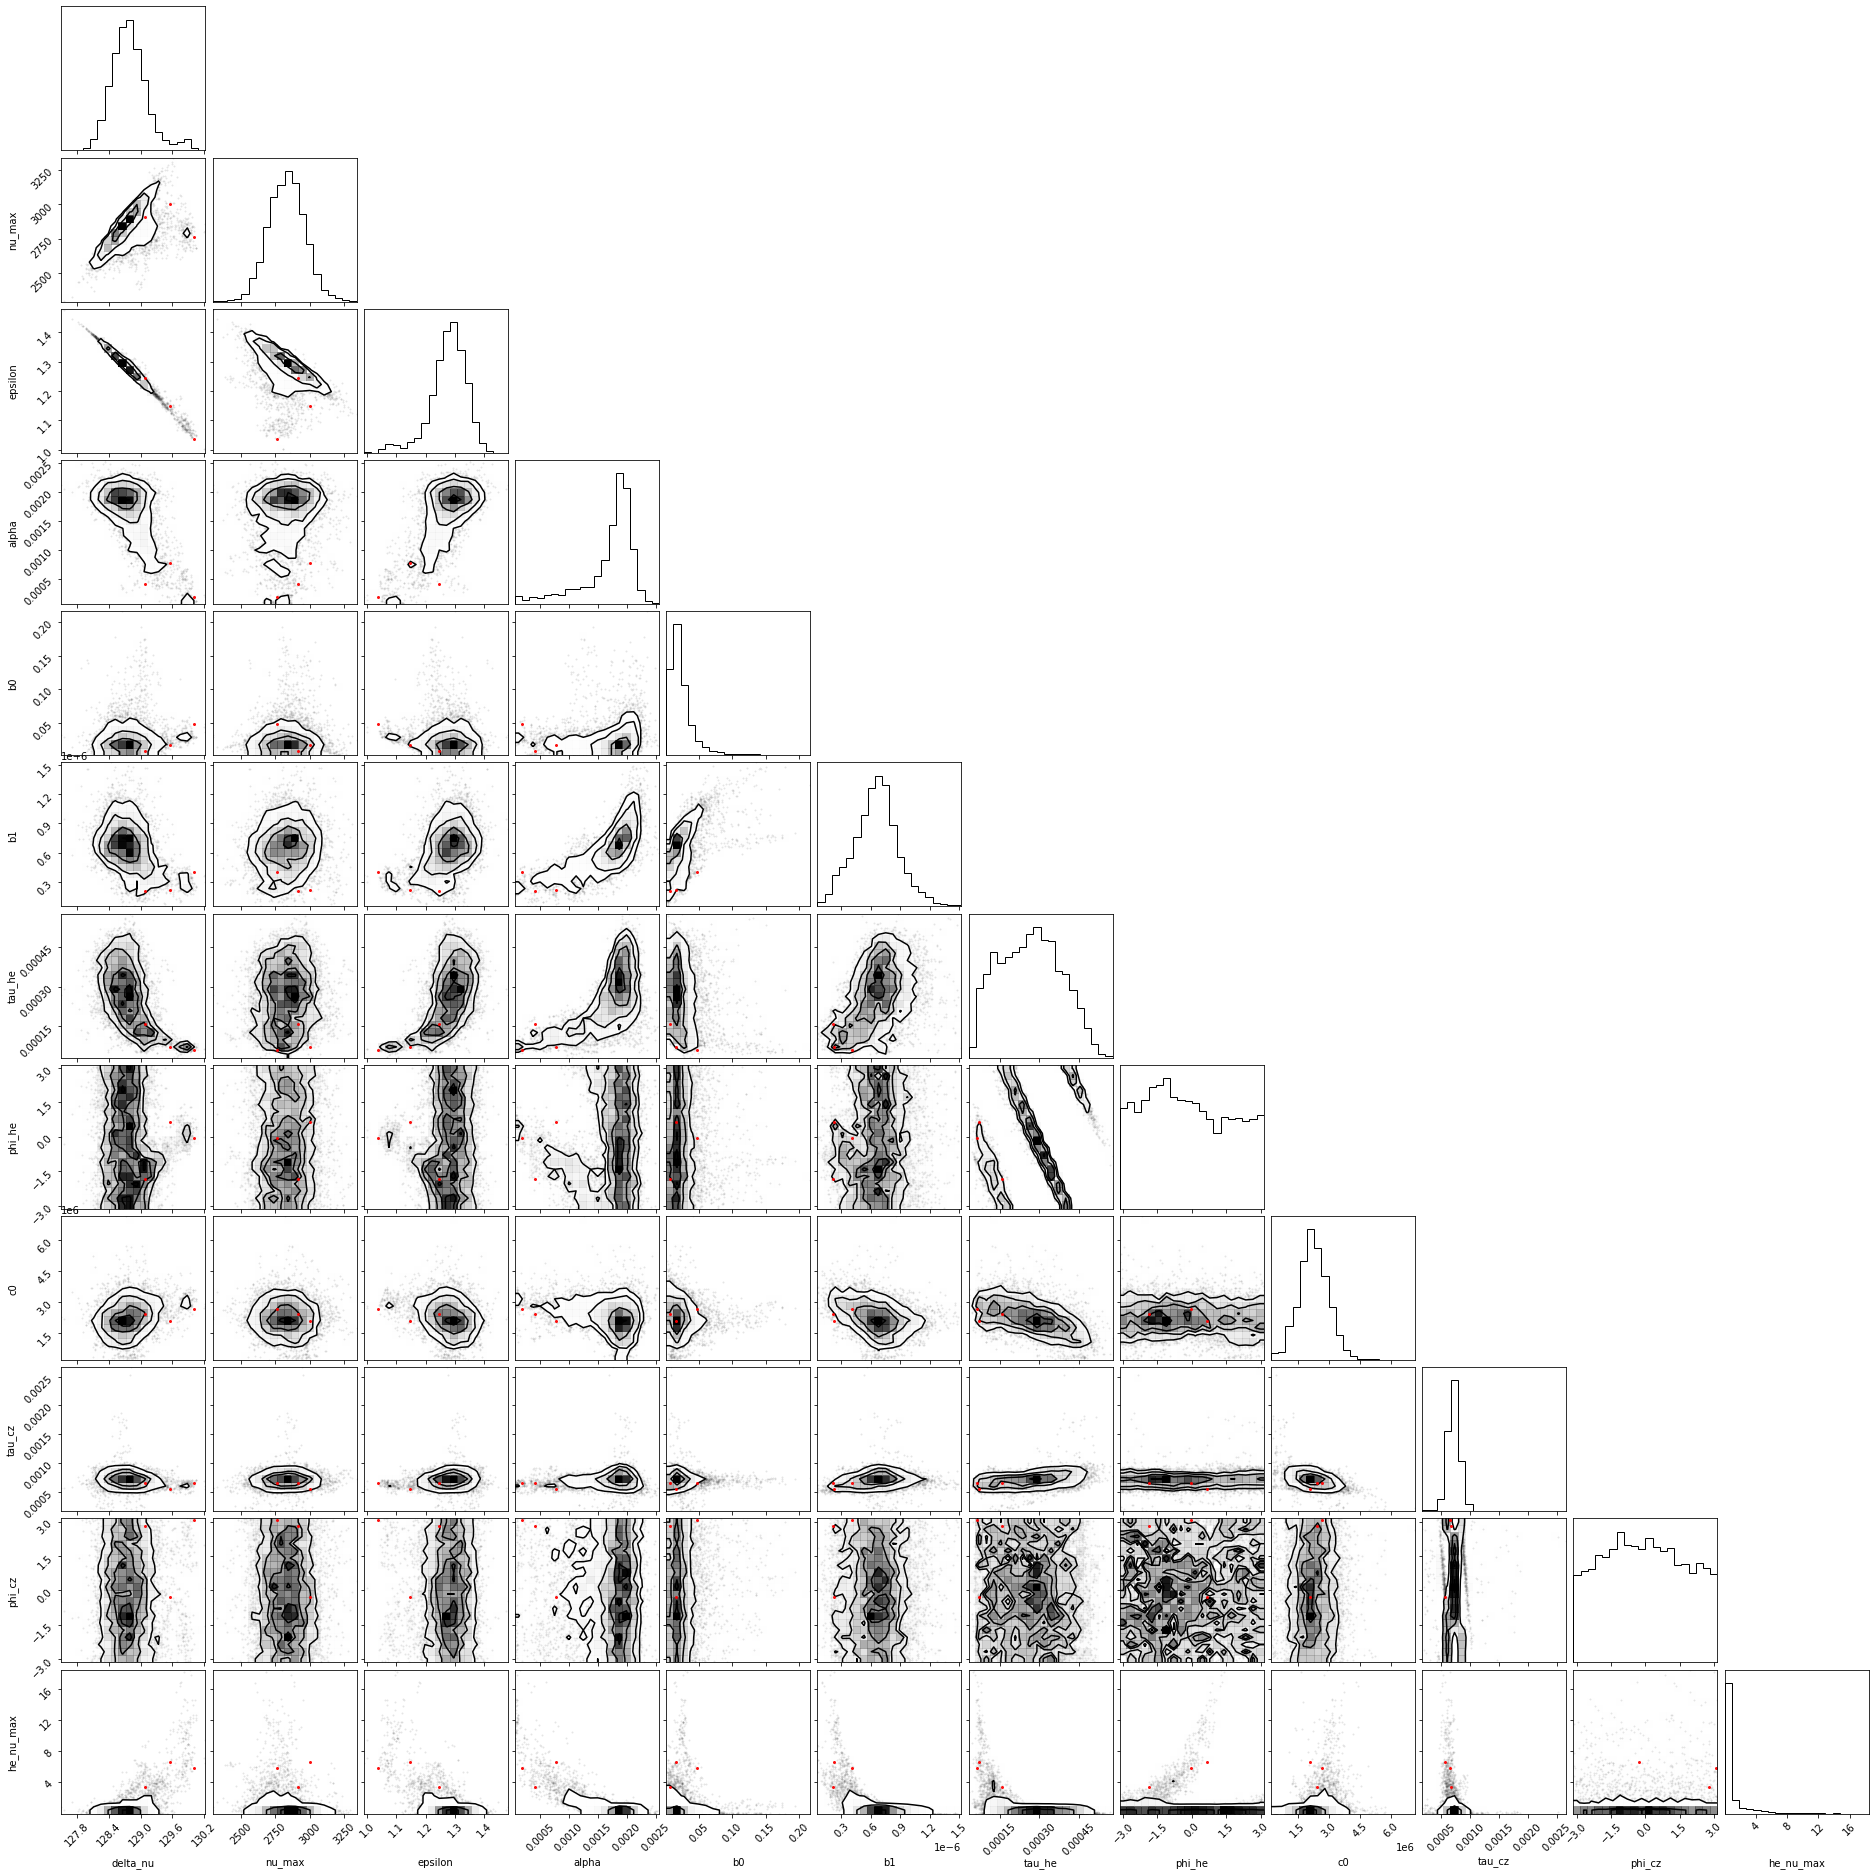

In [37]:
corner(
    trace, 
    var_names=var_names, 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4}
);

In [ ]:
trace.posterior.to_array()

In [50]:
posterior_predictive = Predictive(glitch.prior, posterior_samples=posterior_samples, batch_ndims=2)

In [51]:
rng_seed, rng_key = random.split(rng_seed)

In [52]:
posterior_predictive_samples = posterior_predictive(rng_key)

In [53]:
trace.add_groups(group_dict={
    'posterior_predictive': posterior_predictive_samples
})

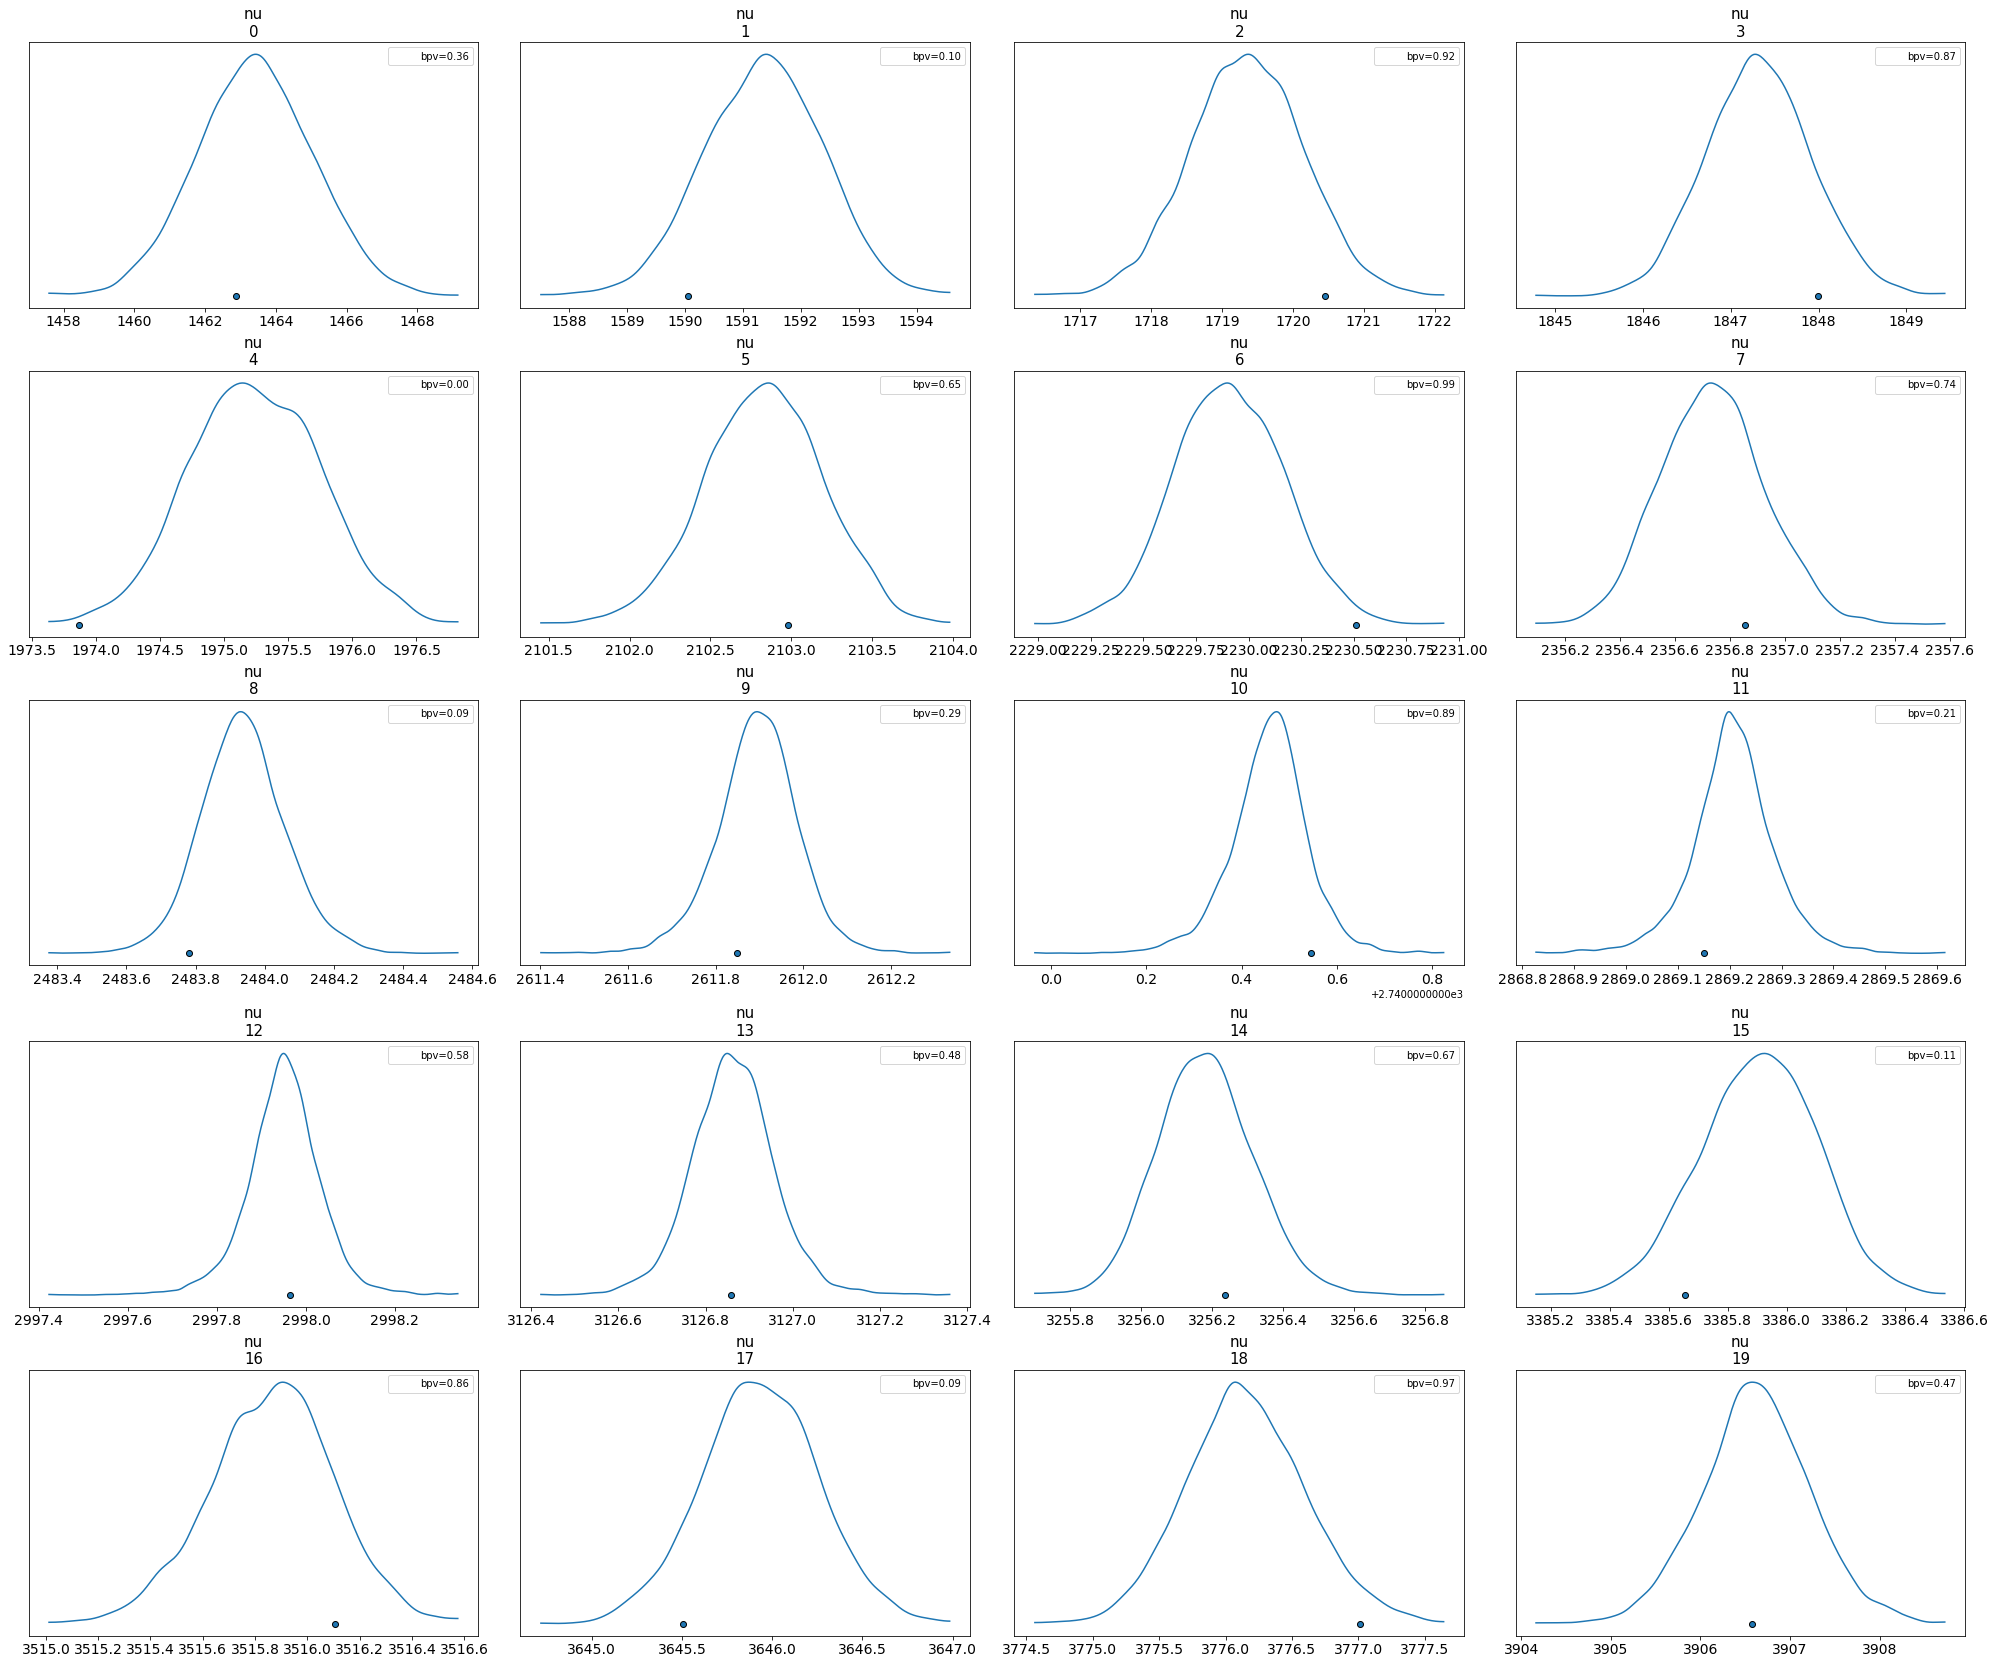

In [54]:
ax = az.plot_bpv(trace, group='posterior', kind='t_stat', flatten=['chain', 'draws']);

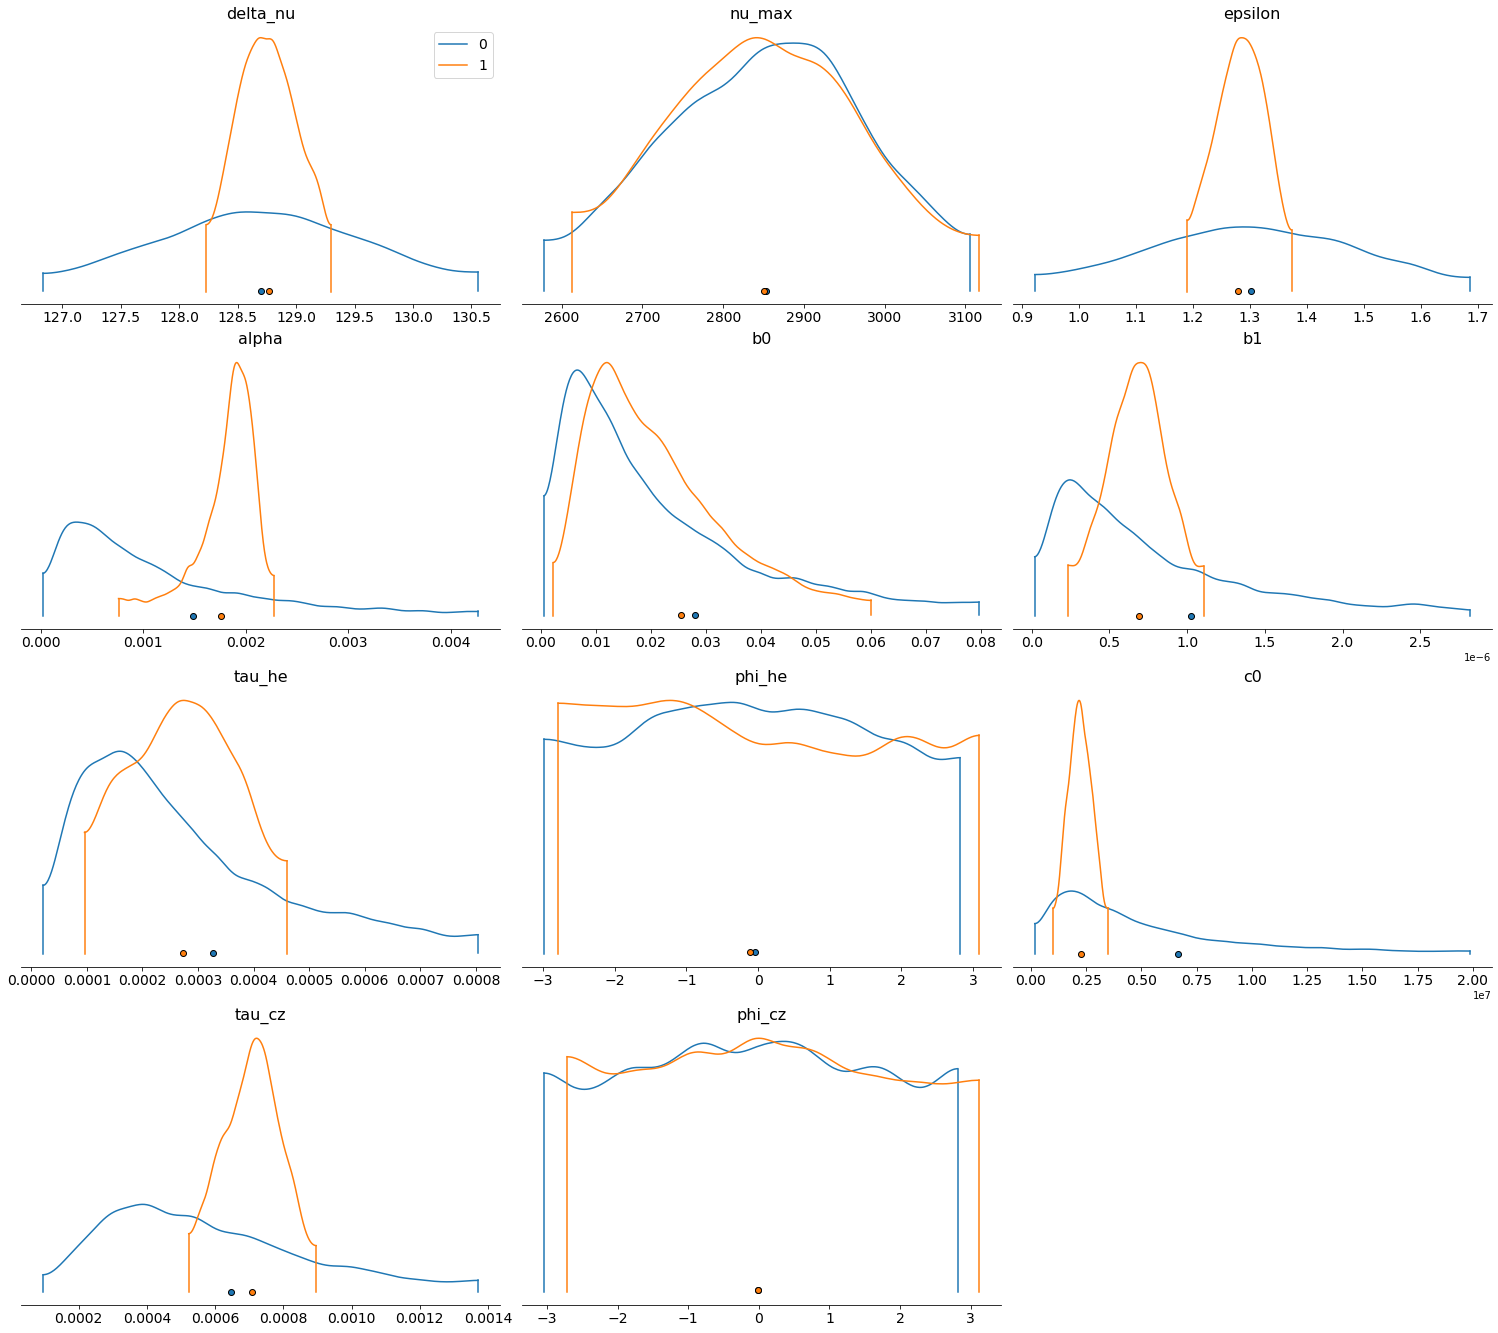

In [58]:
az.plot_density([trace.prior_predictive, trace.posterior], var_names=var_names);

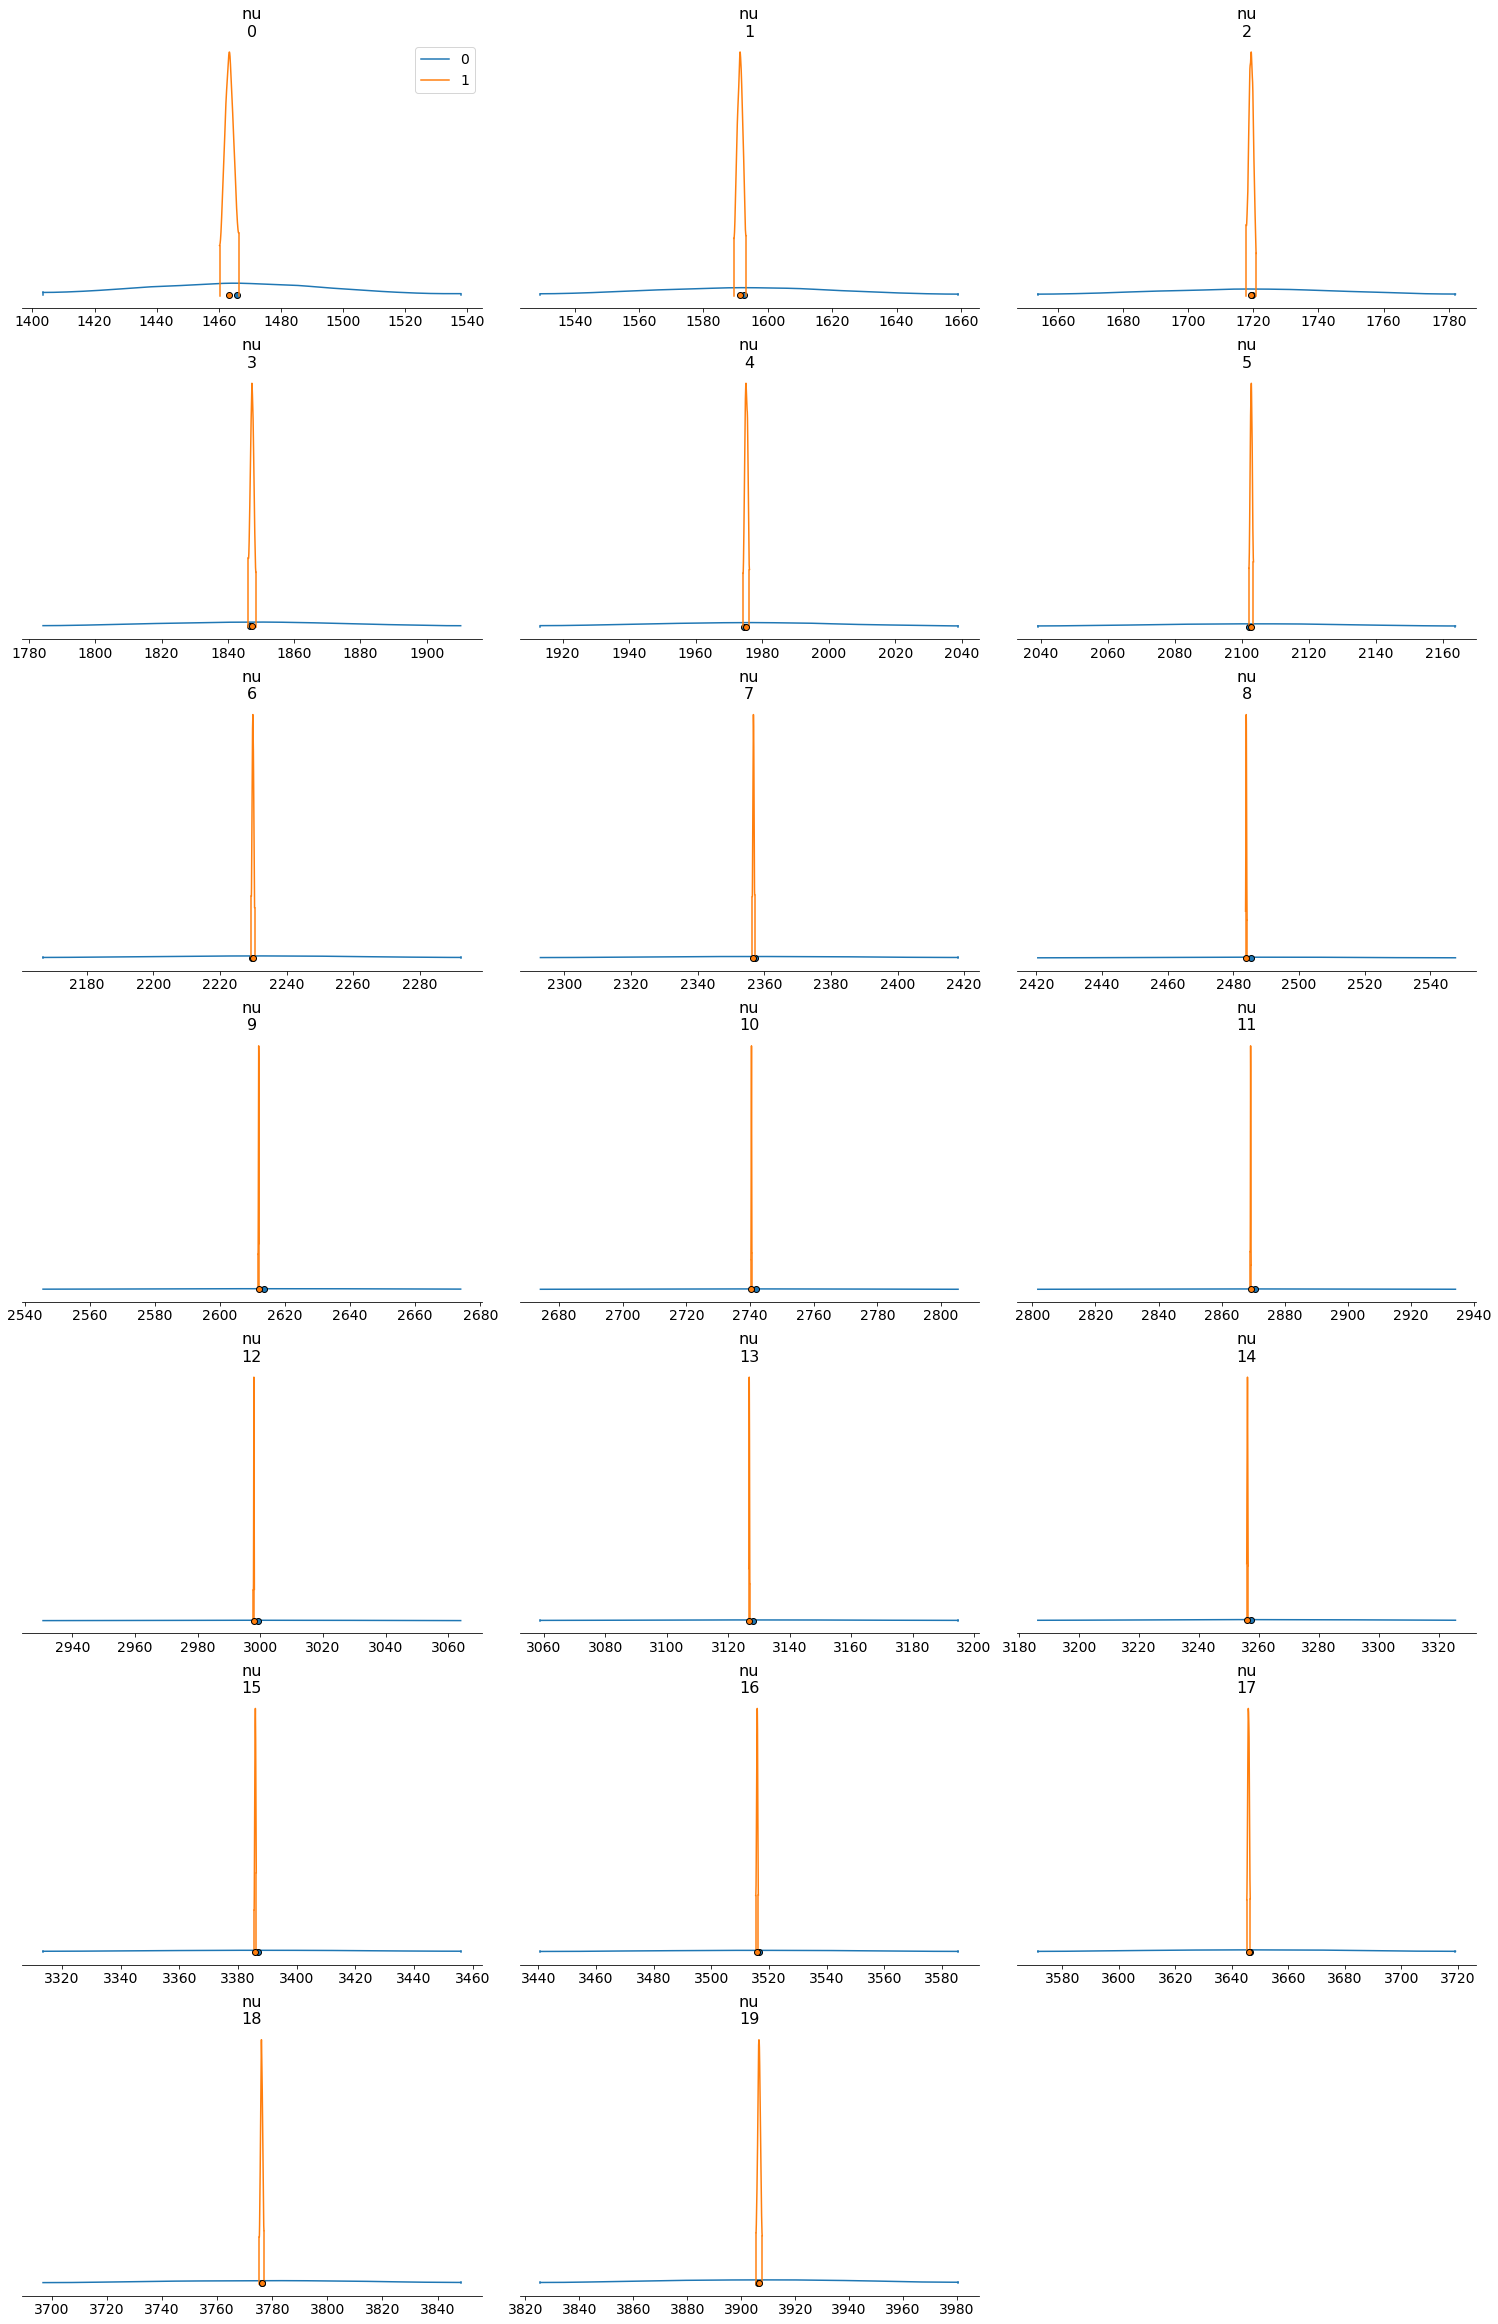

In [59]:
az.plot_density([trace.prior_predictive, trace.posterior_predictive], var_names=['nu']);

In [61]:
predictions = Predictive(glitch.predictions, posterior_samples=posterior_samples, batch_ndims=2)

In [62]:
rng_seed, rng_key = random.split(rng_seed)
prediction_samples = predictions(rng_key)

In [71]:
trace = az.from_dict(
    posterior=posterior_samples,
    posterior_predictive=posterior_predictive_samples,
    predictions=prediction_samples,
    sample_stats=sample_stats,
    prior_predictive=prior_predictive_samples,
    observed_data=glitch.observed_data,
    constant_data=glitch.constant_data,
    predictions_constant_data=glitch.predictions_constant_data
)
trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> predictions
	> sample_stats
	> prior_predictive
	> observed_data
	> constant_data
	> predictions_constant_data

In [151]:
def combine_chains(x):
    return jnp.reshape(x, (x.shape[0]*x.shape[1], *x.shape[2:]))

In [154]:
n = prior.n

nu_model = combine_chains(samples['nu'])
num_modes = nu_model.shape[1]

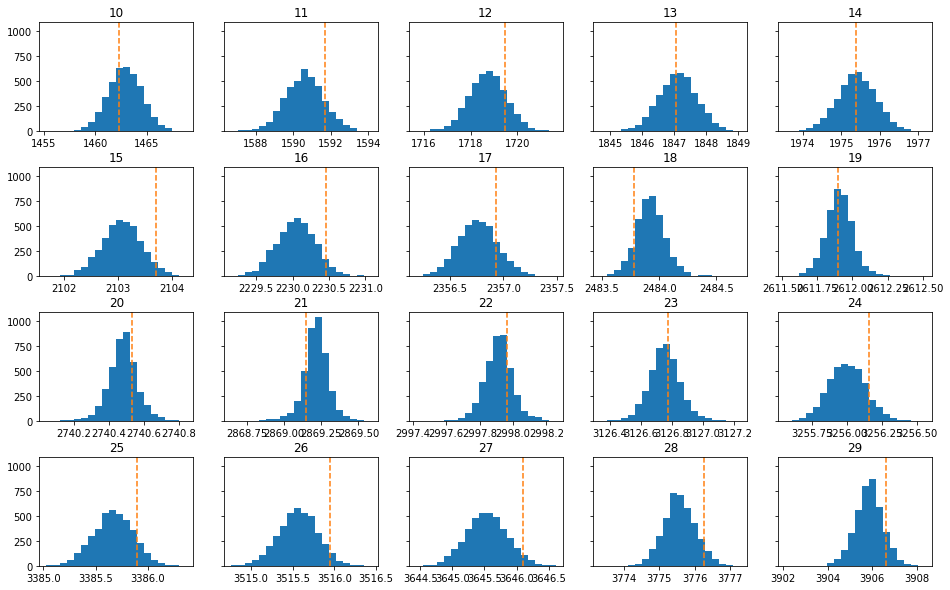

In [155]:
nrows = int(np.floor(np.sqrt(num_modes)))
ncols = int(np.ceil(num_modes/nrows))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), sharey=True,
                        gridspec_kw={'hspace': .33})

for ax, nu_m, nu_t, _n in zip(np.ravel(axes), nu_model.T, nu, n):
    ax.hist(nu_m, bins=20, color='C0')
    ax.axvline(nu_t, color='C1', linestyle='--')
    ax.ticklabel_format(useOffset=False)
    ax.set_title(f'{_n}')